<a href="https://colab.research.google.com/github/mrudan2020/mvp2-pucrj/blob/main/Modelo_1_classificacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo ML para detecção de doenças apartir de sintomas conhecidos

## Problemática:

Muitas são as doenças que podem afetar a população humana, um diagnóstico e tratamento eficaz são fundamentais para o combate (cura) à uma doença.

Através do Dataset:

https://www.kaggle.com/datasets/uom190346a/disease-symptoms-and-patient-profile-dataset

Iremos desenvolver um modelo que tenha a capacidade de diagnosticar uma a partir de seus sintomas relatados

## Dataset doc

 Disease: doença (hipótese)

---


 Fever: presença de febre


---


 Cough: presença de tosse

---


 Fatigue: cansaço


---


 Difficulty Breathing: dificuldade em respirar


---


 Age: idade


---


 Gender: sexo


---


 Blood Pressure: pressão sanguinea


---


 Cholesterol Level: colesterol


---


Outcome Variable: confimarção por exame do diagnóstico (col1 Disease)

## Organização

Parte da estrutura de códigos do 1º MVP será utilizada neste trabalho:
https://github.com/mrudan2020/pucrj-mvp1/blob/main/MVP1.ipynb

O código está estruturado em 4 etapas:

1. Bibliotecas de importação
2. Classe Utils com as funcoes utilizadas no código
3. Exploracao da base de dados
4. Geracao de uma V0 sem ajustes ou tratamentos dos dados
5. Geracao de uma V1 com feature selection
6. Geracao de uma V2 utilizando a lib tpot
7. Geracao de uma v3 com ajustes na target
8. Conclusão

## Libs

In [1]:
import pandas as pd
import numpy as np
from google.colab import files
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, f1_score

In [2]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada
from sklearn.model_selection import cross_val_score # para executar a validação cruzada
from sklearn.metrics import accuracy_score # para a exibição da acurácia do modelo
from sklearn.neighbors import KNeighborsClassifier # algoritmo KNN
from sklearn.tree import DecisionTreeClassifier # algoritmo Árvore de Classificação
from sklearn.naive_bayes import GaussianNB # algoritmo Naive Bayes
from sklearn.svm import SVC # algoritmo SVM
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

## Config Pandas

In [3]:
# Definindo as opções de configuração para pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Utils

In [4]:
class Utils:
  def __init__(self, url):
    self.url=url

  def ler_csv(self):
    self.df=pd.read_csv(self.url)

  def distribuicao_target(self, num_categ, col_target_name):
    contagem_categorias = self.df[col_target_name].value_counts()
    # Escolha o número de categorias mais comuns que você deseja exibir no gráfico
    numero_categorias_comuns = num_categ
    #Seleciona as 'numero_categorias_comuns' categorias mais comuns
    categorias_comuns = contagem_categorias.nlargest(numero_categorias_comuns)
    # Plot do gráfico de barras
    plt.figure(figsize=(10, 6))
    sns.barplot(x=categorias_comuns.index, y=categorias_comuns.values)
    plt.xlabel('Categoria')
    plt.ylabel('Contagem')
    plt.title(f'{numero_categorias_comuns} Categorias Mais Comuns')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

  def gerar_tabela_distribuicao_categorica(self, name_col_categ):
    # Calcule a frequência das categorias e o acumulado percentual
    frequencia = self.df[name_col_categ].value_counts()
    acumulado_percentual = (frequencia / frequencia.sum()).cumsum()

    # Crie um novo DataFrame com as informações de frequência e acumulado percentual
    self.tabela_acumulada=pd.DataFrame({'Frequência': frequencia, 'Acumulado %': round(100*acumulado_percentual,1)})
    # Plote a tabela
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    ax.axis('off')  # Remove os eixos
    ax.table(cellText=self.tabela_acumulada.values, colLabels=self.tabela_acumulada.columns, rowLabels=self.tabela_acumulada.index, loc='center')
    plt.show()

  def gerar_distribuicao_numerica(self, col_name_num, col_name_categ):
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=self.df, x=col_name_categ, y=col_name_num)
    plt.xlabel(col_name_categ)
    plt.ylabel(col_name_num)
    plt.title('Violin Plot para Duas Categorias')
    plt.show()

  def transformar_dataset(self, col_target_name):
    self.target=self.df[col_target_name]
    self.colunas_numericas = self.df.select_dtypes(include=np.number).columns.tolist()
    colunas_categoricas=self.df.select_dtypes(exclude=np.number).columns.tolist()

    colunas_dict = {}

    # Crie uma instância do LabelEncoder
    label_encoder = LabelEncoder()

    for coluna in colunas_categoricas:
        colunas_dict[coluna] = label_encoder.fit_transform(self.df[coluna])

    self.df_categoricos_transformed=pd.DataFrame(colunas_dict)

  def modelagem(self, X_train, y_train):
    # Lista que armazenará os modelos
    models = []

    # Criando os modelos e adicionando-os na lista de modelos
    models.append(('LR', LogisticRegression(max_iter=200)))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('SVM', SVC()))

    # Definindo os parâmetros do classificador base para o BaggingClassifier
    base = DecisionTreeClassifier()
    num_trees = 75
    max_features = 5

    # Criando os modelos para o VotingClassifier
    bases = []
    model1 = LogisticRegression(max_iter=200)
    bases.append(('logistic', model1))
    model2 = DecisionTreeClassifier()
    bases.append(('cart', model2))
    model3 = SVC()
    bases.append(('svm', model3))

    # Criando os ensembles e adicionando-os na lista de modelos
    models.append(('Bagging', BaggingClassifier(base_estimator=base, n_estimators=num_trees)))
    models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
    models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
    models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
    models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
    models.append(('Voting', VotingClassifier(bases)))

    # Listas para armazenar os resultados
    results = []
    names = []

    # Avaliação dos modelos
    for name, model in models:
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

    self.results=results
    self.names=names
    self.models=models

# Main

## Lendo o dataset

In [5]:
url_dados="https://raw.githubusercontent.com/mrudan2020/teste/main/Disease_symptom_and_patient_profile_dataset.csv"

base_dados=Utils(url_dados)
base_dados.ler_csv()

In [6]:
base_dados.df.head(3)

,Disease,Fever,Cough,Fatigue,Difficulty Breathing,Age,Gender,Blood Pressure,Cholesterol Level,Outcome Variable
0,Influenza,Yes,No,Yes,Yes,19,Female,Low,Normal,Positive
1,Common Cold,No,Yes,Yes,No,25,Female,Normal,Normal,Negative
2,Eczema,No,Yes,Yes,No,25,Female,Normal,Normal,Negative


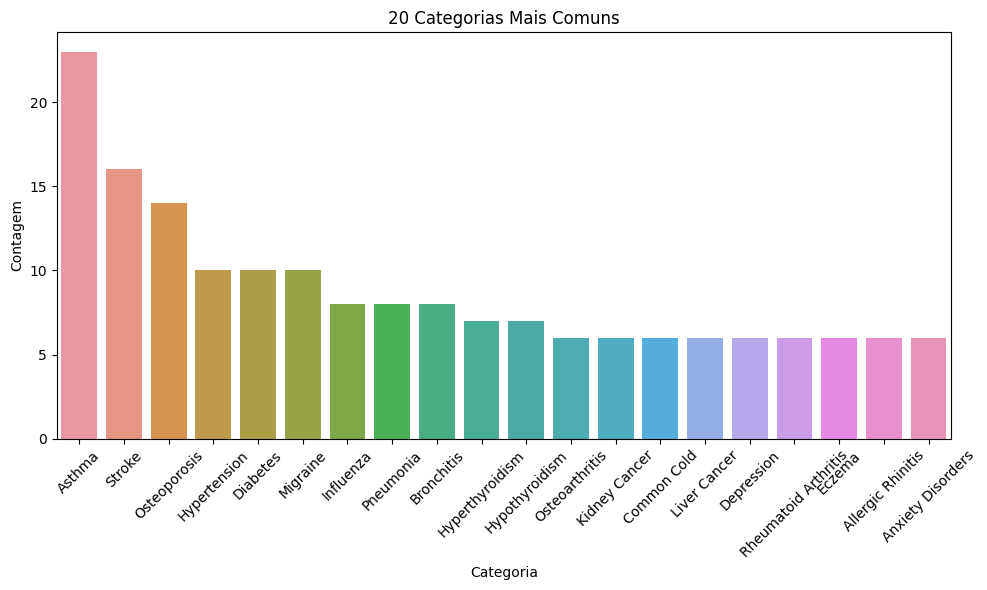

In [7]:
base_dados.distribuicao_target(num_categ=20, col_target_name="Disease")

### Análise da distribuição numérica

No nosso dataset há apenas uma variável numérica (idade).
Por isso iremos explorar esta mais abaixo, partindo de alguns pressupostos importantes como:


1.   A idade é um fator de risco, pois conforme envelhecemos há uma diminuição do sistema imunológico
2.   Aspectos de sedentarismo e má alimentação tendem a ser mais comuns pessoas mais velhas do que em jovens
3.   Mulheres tendem a ser mais cautelosas com a saúde do que homens

Importante ressaltar que os tópicos acima refletem uma visão simplista do comportamento esperado dos dados. Após as análises poderemos ter maiores indícios sobre os pontos aqui apresentados.





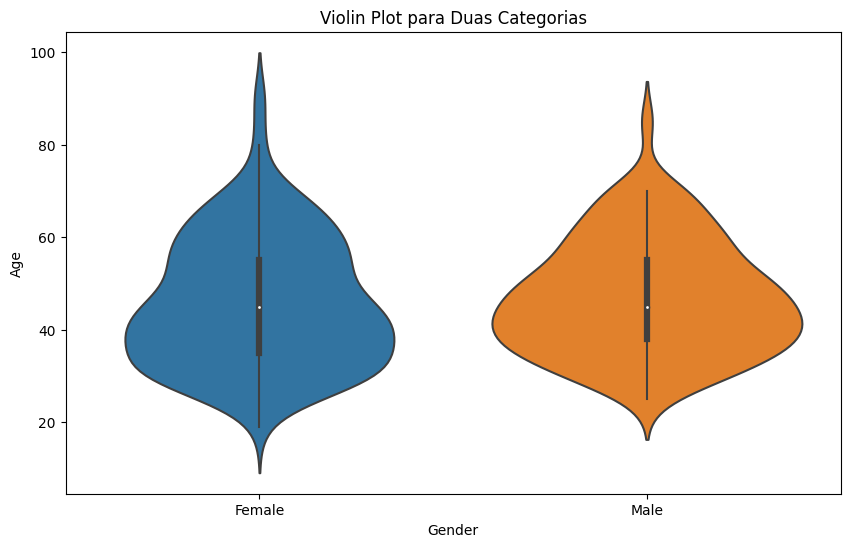

In [8]:
base_dados.gerar_distribuicao_numerica('Age','Gender')

Na nossa amaostra fica claro, que há um número de mulheres com idade superior a 90 anos em relação aos homens. Obviamente por se tratar de uma amostra é difícil tirar qual quer conclusão. Além disso, vale lembrar que os dados em questão vieram de pessoas doentes com alguma doença diagnosticada.

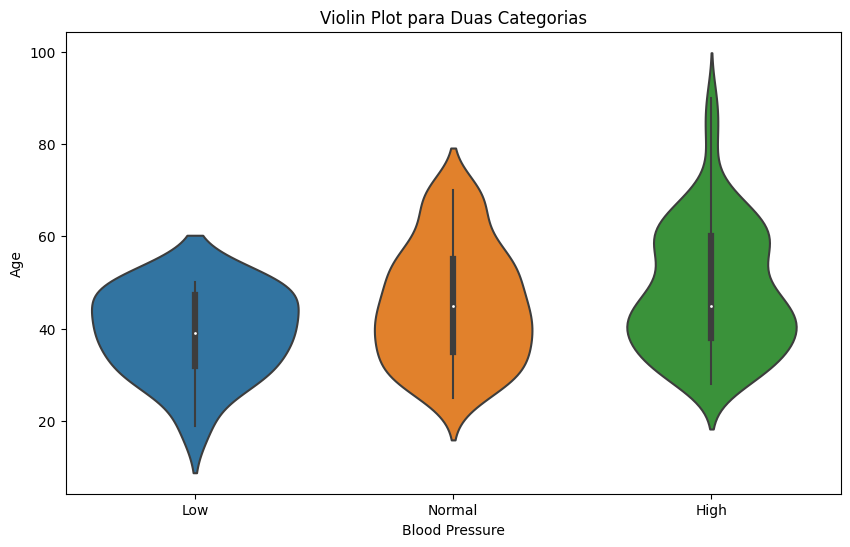

In [9]:
base_dados.gerar_distribuicao_numerica('Age','Blood Pressure')

Como apontado no início das análises, é possível percebermos que pessoas com pressão sanguínea alta (verde) tendem a ocorrer em pessoas mais velhas com idade superior aos 75 anos. Vale reforçar que os níveis de pressão sanguínea abordado nesta amostra atingiram todos os patamares de idade, não sendo um aspecto exclusivamente em idosos, apesar de ser mais comum.

Um último ponto em detaque paira sobre a população com pressão sanguínea baixa, com uma maior concetração entre 20 e 50 anos, e não sendo observado em pessoas com +65 anos.

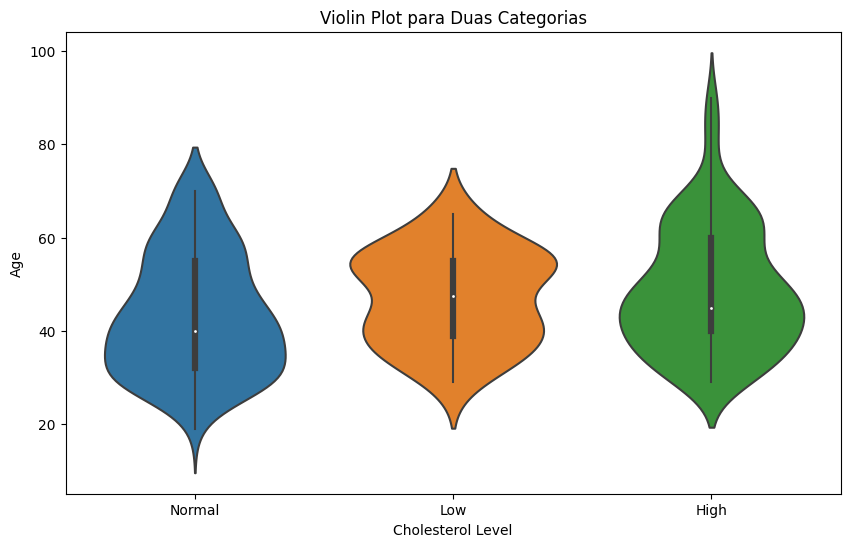

In [10]:
base_dados.gerar_distribuicao_numerica('Age','Cholesterol Level')

A análise de níveis de colesterol perante a idade teve um comportamento similar ao de pressão sanguínea para os grupos com taxas elevadas. Neste grupo ficou evidente a parcela de pessoas com idade +80

### Frequência dos dados de target

In [11]:
print(f'Número total de doenças na base é de {len(base_dados.df.Disease.unique())}')

Número total de doenças na base é de 116


Notem que a variável target possui um grande número de possibilidades, entretanto quando olhamos a distribuição acumulada das variaveis target, constatamos a pequena amostragem de algumas classificações.


---

E pequena amostragem de alguns casos poderá não ser detectado pelo modelo ou até mesmo impactar na detecção das doenças mais comuns

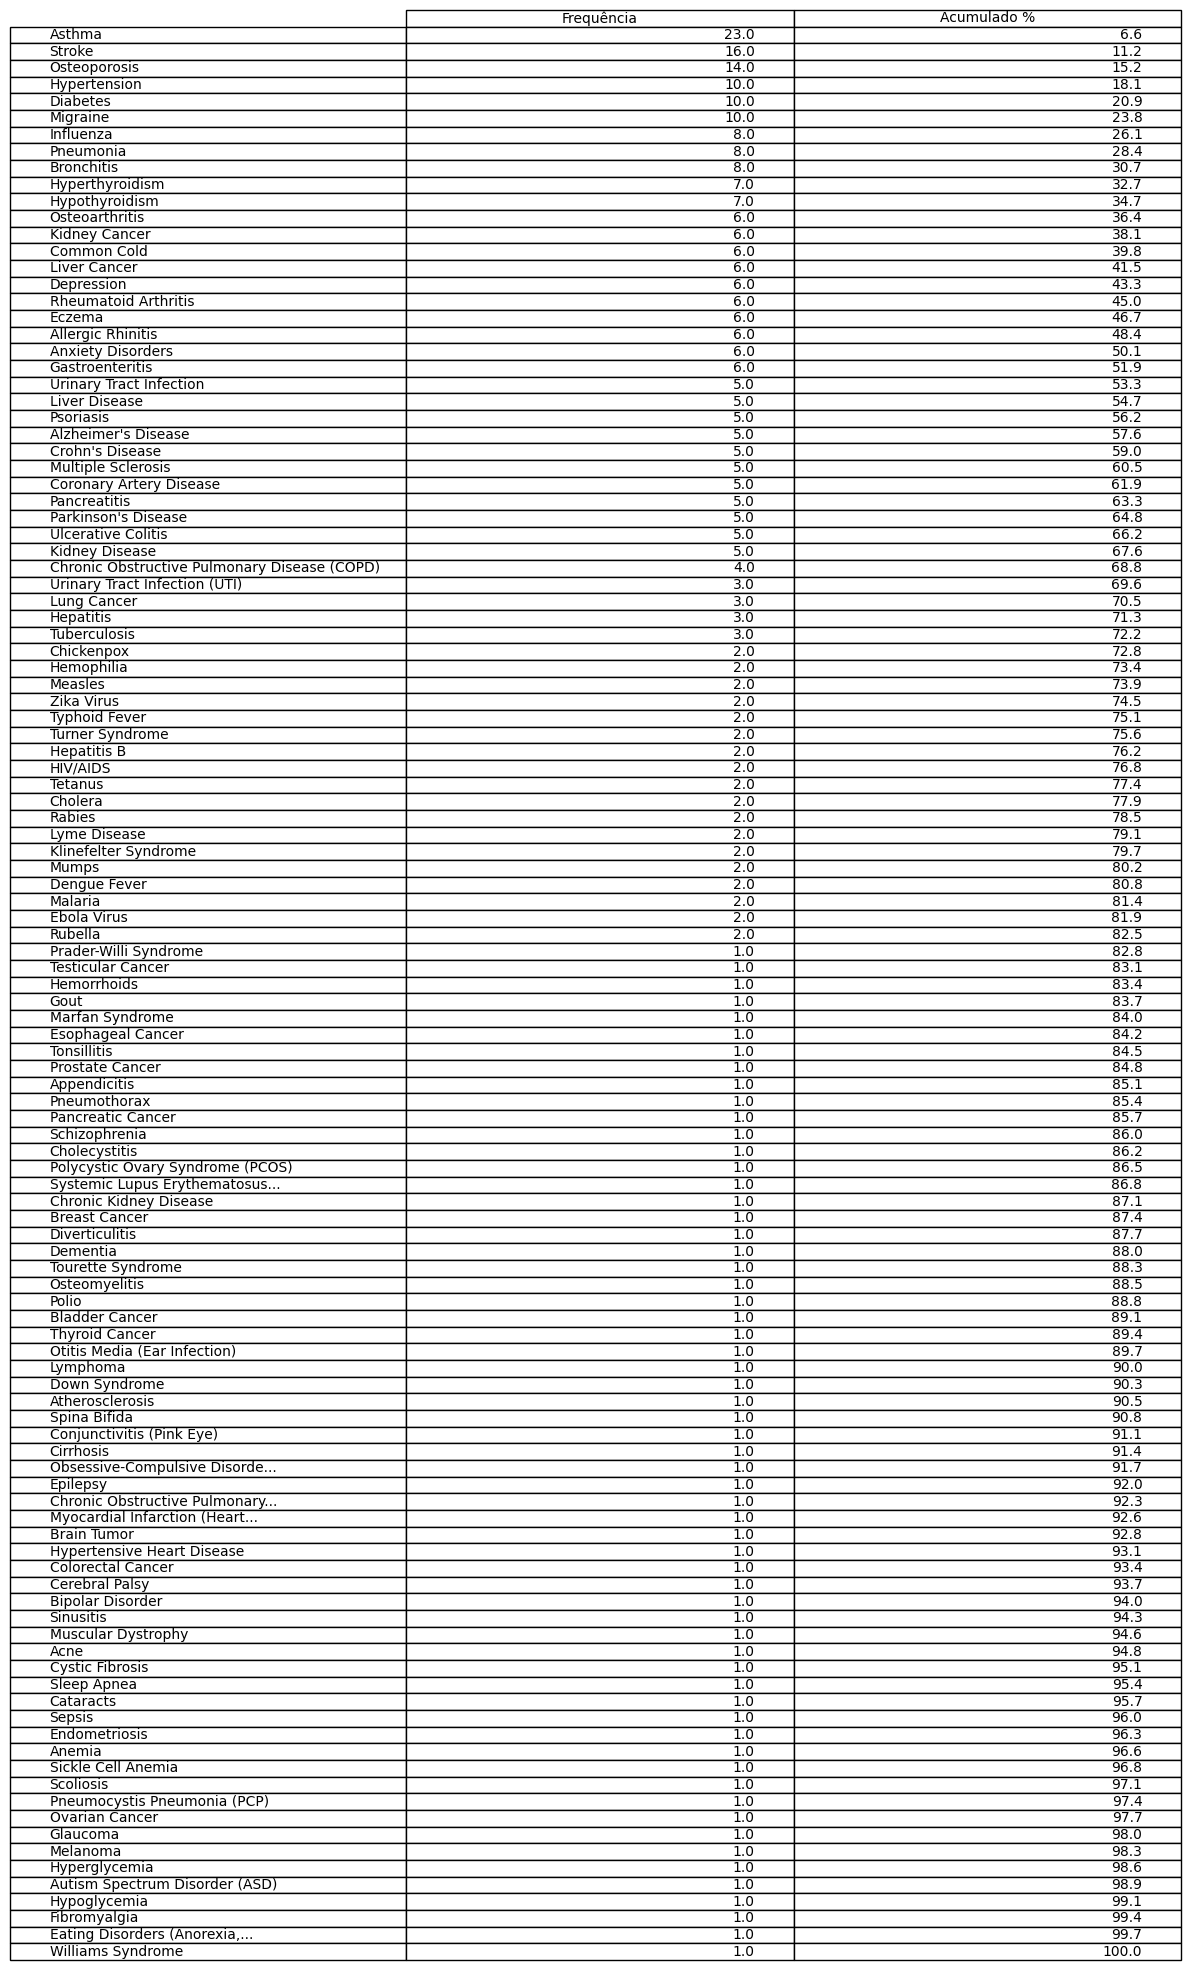

In [12]:
base_dados.gerar_tabela_distribuicao_categorica(name_col_categ="Disease")

### Transformação dos dados

A maior parcela de dados categoricos devem ser tranformados para serem utilizados no nosso modelo

In [13]:
base_dados.transformar_dataset("Disease")

In [14]:
base_dados.df_categoricos_transformed

,Disease,Fever,Cough,Fatigue,Difficulty Breathing,Gender,Blood Pressure,Cholesterol Level,Outcome Variable
0,56,1,0,1,1,0,1,2,1
1,24,0,1,1,0,0,2,2,0
2,37,0,1,1,0,0,2,2,0
3,6,1,1,0,1,1,2,2,1
4,6,1,1,0,1,1,2,2,1
5,37,1,0,0,0,0,2,2,1
6,56,1,1,1,1,0,2,2,1
7,56,1,1,1,1,0,2,2,1
8,53,0,1,0,0,0,2,2,0
9,53,0,1,0,0,0,2,2,0


Para a primeira rodada iremos elaborar um modelo com todas as variáveis disponiveis e sem qualquer tipo de ajuste

In [15]:
colunas_numericas=base_dados.colunas_numericas
df_raw_v0=pd.concat([base_dados.df_categoricos_transformed, base_dados.df[colunas_numericas]], axis=1)

df_raw_v0.head(3)

,Disease,Fever,Cough,Fatigue,Difficulty Breathing,Gender,Blood Pressure,Cholesterol Level,Outcome Variable,Age
0,56,1,0,1,1,0,1,2,1,19
1,24,0,1,1,0,0,2,2,0,25
2,37,0,1,1,0,0,2,2,0,25


### Holdout V0

In [16]:
X = df_raw_v0.iloc[:, 1:10]
y = df_raw_v0.iloc[:, :1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=180489)

num_particoes = 10 # número de folds da validação cruzada
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=5) # faz o particionamento em 10 folds

In [17]:
base_dados.modelagem(X_train, y_train)

LR: 0.075296 (0.039411)
KNN: 0.048419 (0.057409)
CART: 0.159091 (0.064647)
NB: 0.106917 (0.066952)
SVM: 0.097431 (0.068026)
Bagging: 0.154743 (0.061988)
RF: 0.163636 (0.064487)
ET: 0.154941 (0.065440)
Ada: 0.048617 (0.041372)
GB: 0.150395 (0.064992)
Voting: 0.110672 (0.049209)


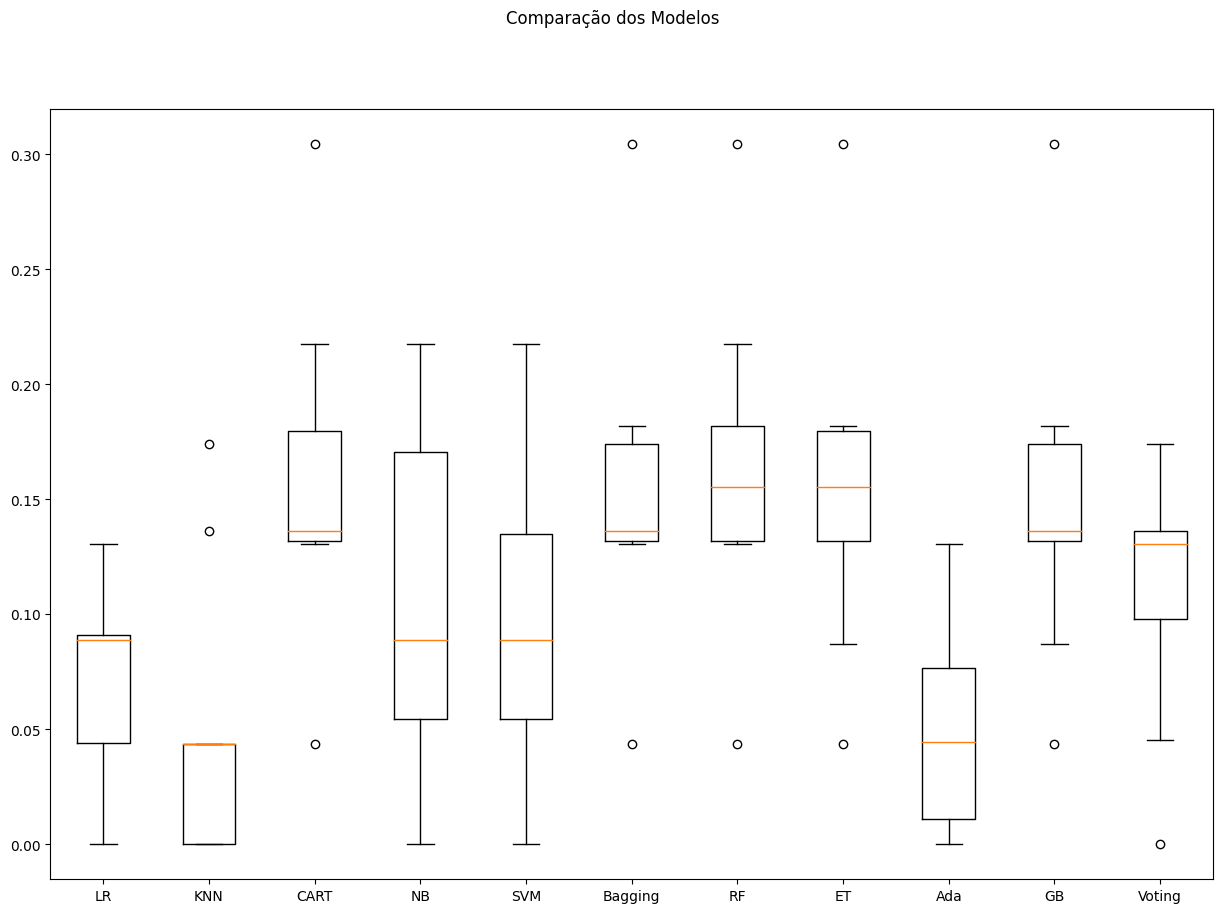

In [18]:
# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(base_dados.results)
ax.set_xticklabels(base_dados.names)
plt.show()

In [19]:
base_dados.models[5]

('Bagging',
 BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=75))

In [20]:
bagg = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=75)
bagg.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = bagg.predict(X_test)

# Calcular a acurácia do modelo
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia do modelo:", accuracy)

Acurácia do modelo: 0.22764227642276422


Como vimos acima, o modelo com o melhor desempenho foi o modelo BaggingClassifier, com uma acurácia baixo de ~22%

### V1

Seguindo o mesmo processo, porém utilizando feature selection para verificar se uma melhor escolha de features pode agregar ao modelo criado

In [21]:
# SelectKBest
best_var = SelectKBest(score_func=f_classif, k=5)

# Executa a função de pontuação em (X, y) e obtém os atributos selecionados
fit = best_var.fit(X, y)

# Reduz X para os atributos selecionados
features = fit.transform(X)

# Resultados
print('\nNúmero original de atributos:', X.shape[1])
print('\nNúmero reduzido de atributos:', features.shape[1])

# Exibe os atributos orginais
print("\nAtributos Originais:", df_raw_v0.columns[1:10])

# Exibe as pontuações de cada atributos e os 4 escolhidas (com as pontuações mais altas)
np.set_printoptions(precision=3) # 3 casas decimais
print("\nScores dos Atributos Originais:", fit.scores_)
print("\nAtributos Selecionados:", best_var.get_feature_names_out(input_features=df_raw_v0.columns[1:10]))

atributos_v1=best_var.get_feature_names_out(input_features=df_raw_v0.columns[1:10]).tolist()


Número original de atributos: 9

Número reduzido de atributos: 5

Atributos Originais: Index(['Fever', 'Cough', 'Fatigue', 'Difficulty Breathing', 'Gender',
       'Blood Pressure', 'Cholesterol Level', 'Outcome Variable', 'Age'],
      dtype='object')

Scores dos Atributos Originais: [1.263 1.103 0.982 3.57  0.936 1.185 1.392 1.123 2.914]

Atributos Selecionados: ['Fever' 'Difficulty Breathing' 'Blood Pressure' 'Cholesterol Level' 'Age']


In [22]:
X = df_raw_v0[atributos_v1]
y = df_raw_v0.iloc[:, :1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=180489)

num_particoes = 5
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=5)

In [23]:
base_dados.modelagem(X_train, y_train)

LR: 0.075169 (0.026484)
KNN: 0.061739 (0.031943)
CART: 0.084058 (0.008728)
NB: 0.070821 (0.016717)
SVM: 0.101546 (0.051148)
Bagging: 0.079517 (0.026115)
RF: 0.101643 (0.029562)
ET: 0.088309 (0.027202)
Ada: 0.092754 (0.049034)
GB: 0.079517 (0.026115)
Voting: 0.105990 (0.044610)


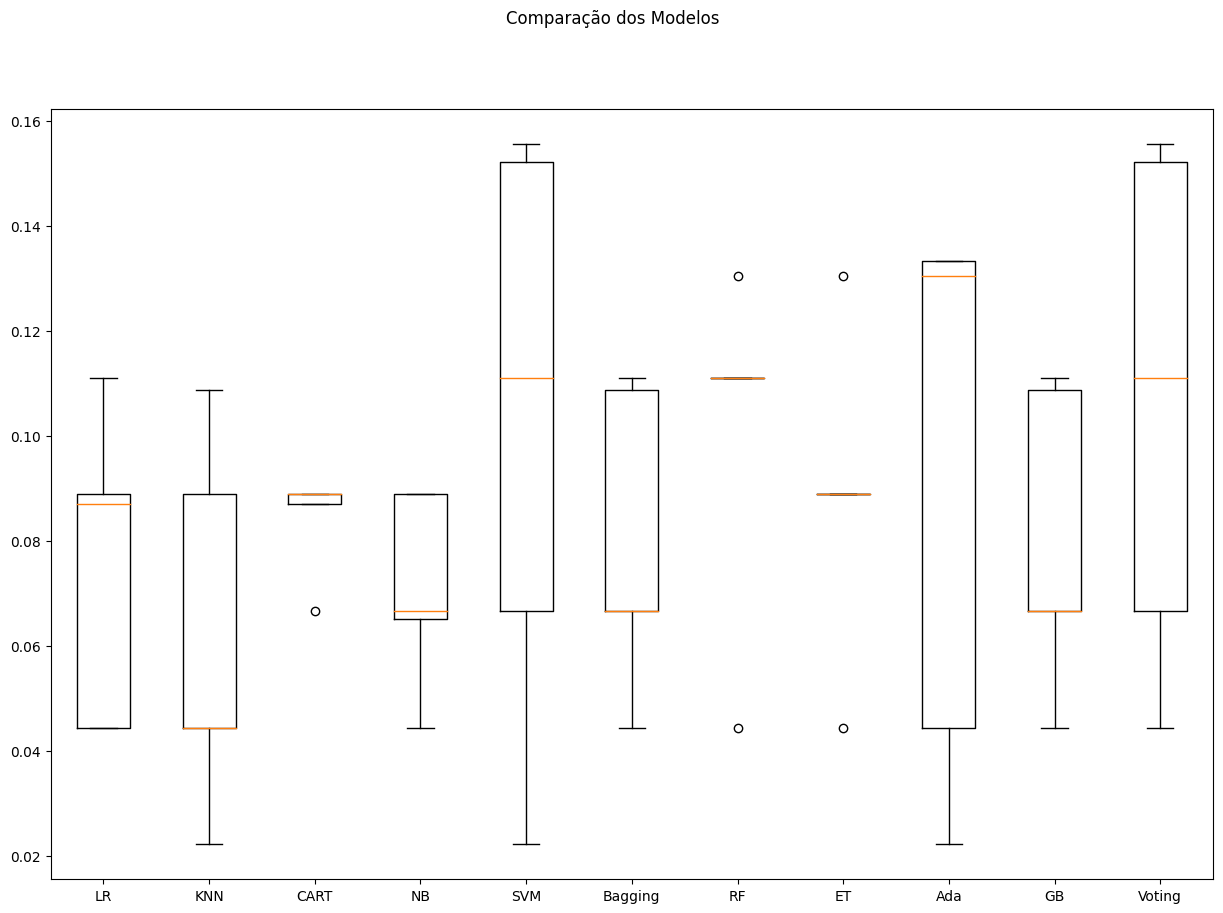

In [24]:
# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(base_dados.results)
ax.set_xticklabels(base_dados.names)
plt.show()

Após a etapa de feature selection não foi observado ganho claro de acurácia.
Algo, inclusive, esperado devido a grande varieade dados na target com baixa frequência.

---

Próxima etapa iremos trabalhar na simplificação da target

### V2

Aqui iremos trabalhar na frequencia da target, reclassificando a mesma em grupos menores, porém em maior quantidade.

Quando examinamos a coluna target, foi possível contabilizar 116 doenças em nossa base. ANalisando a fundo a tabela de frequencia notamos que 68% das doenças na base são referentes a 32 diagnósticos, ou seja 84 doenças da base poderiam ser simplificadas, devido a sua baixa representatividade para melhorar o poder de generalização do modelo

In [25]:
base_dados.tabela_acumulada.head()

,Frequência,Acumulado %
Asthma,23,6.6
Stroke,16,11.2
Osteoporosis,14,15.2
Hypertension,10,18.1
Diabetes,10,20.9


In [26]:
sum((base_dados.tabela_acumulada['Acumulado %']<=68))

32

Frente a este fato, iremos reduzir a target (antes 116) para 32 classes...

In [27]:
target_reduzida=base_dados.tabela_acumulada.iloc[0:32,:].index.tolist()

In [28]:
df_v2=base_dados.df[base_dados.df['Disease'].isin(target_reduzida)].reset_index(drop=True)

In [29]:
target=df_v2['Disease']
colunas_numericas = df_v2.select_dtypes(include=np.number).columns.tolist()
colunas_categoricas=df_v2.select_dtypes(exclude=np.number).columns.tolist()

colunas_dict = {}

    # Crie uma instância do LabelEncoder
label_encoder = LabelEncoder()

for coluna in colunas_categoricas:
    colunas_dict[coluna] = label_encoder.fit_transform(df_v2[coluna])


In [30]:
df_v2=pd.concat([pd.DataFrame(colunas_dict), df_v2[colunas_numericas]], axis=1)

In [31]:
df_v2.shape

(236, 10)

In [32]:
X = df_v2[atributos_v1]
y = df_v2.iloc[:, :1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=180489)

num_particoes = 5
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=5)
base_dados.modelagem(X_train, y_train)

LR: 0.150968 (0.062056)
KNN: 0.091398 (0.077706)
CART: 0.143226 (0.075230)
NB: 0.085161 (0.026491)
SVM: 0.138065 (0.074725)
Bagging: 0.149892 (0.072921)
RF: 0.149892 (0.066970)
ET: 0.150108 (0.076502)
Ada: 0.097849 (0.071681)
GB: 0.143656 (0.071009)
Voting: 0.157204 (0.085818)


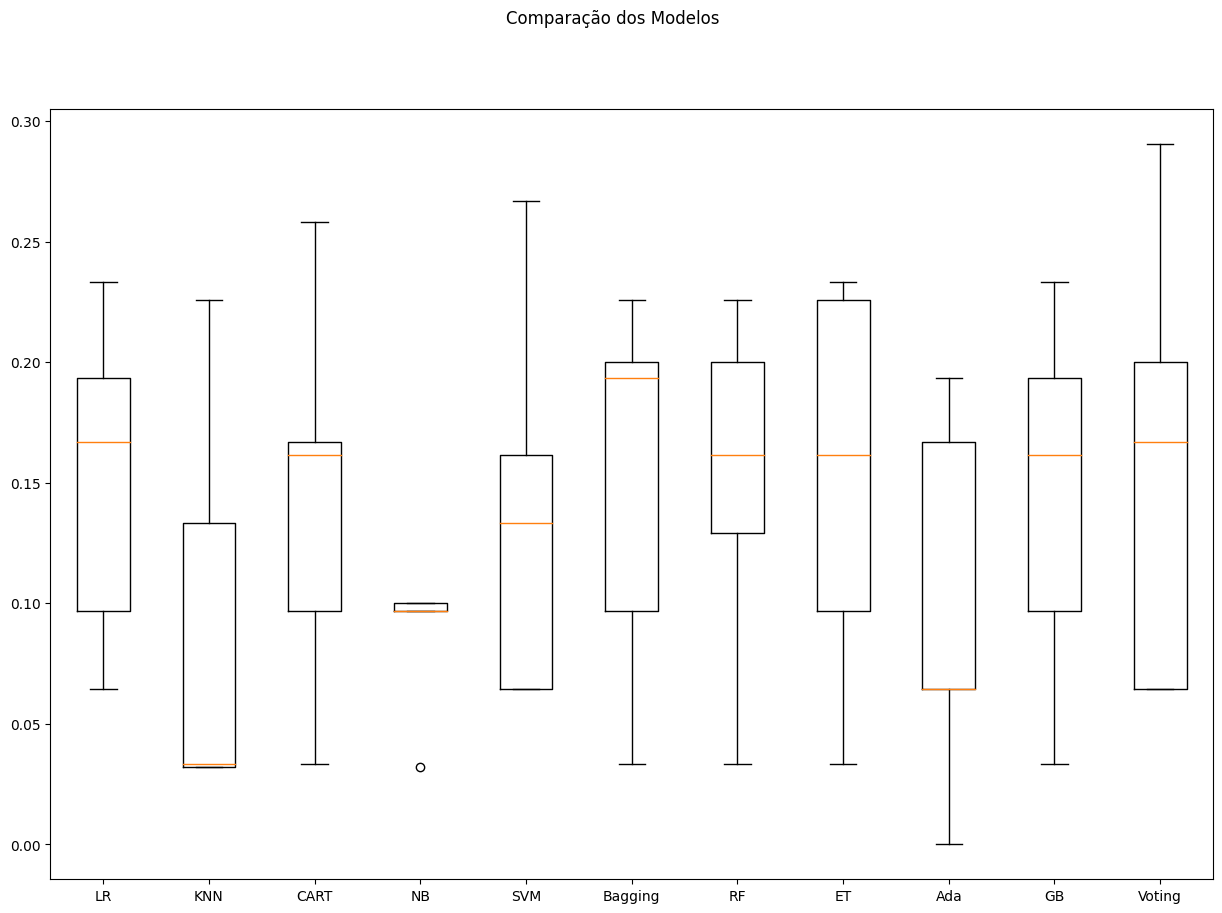

In [33]:
# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(base_dados.results)
ax.set_xticklabels(base_dados.names)
plt.show()

Mesmo com a simplificação da variável target, não foi possível observar melhoras na acurácia. Provavelmente, o número reduzido do dataset pode estar compromentendo a capacidade do modelo generalizar e performar melhor

### V3

Como última tentativa, iremos avaliar o desempenho da lib TPOT

In [34]:
pip install tpot

In [35]:
from tpot import TPOTClassifier

X = df_v2[atributos_v1]
y = df_v2.iloc[:, :1]

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e treinar o pipeline usando TPOTClassifier
pipeline = TPOTClassifier(generations=5, population_size=20, verbosity=2, random_state=42)
pipeline.fit(X_train, y_train)

# Exibir a acurácia do pipeline no conjunto de teste
accuracy = pipeline.score(X_test, y_test)
print("Acurácia do pipeline:", accuracy)

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.16529160739687057

Generation 2 - Current best internal CV score: 0.17539118065433854

Generation 3 - Current best internal CV score: 0.17539118065433854

Generation 4 - Current best internal CV score: 0.18591749644381222

Generation 5 - Current best internal CV score: 0.18591749644381222

Best pipeline: DecisionTreeClassifier(GaussianNB(input_matrix), criterion=gini, max_depth=5, min_samples_leaf=19, min_samples_split=15)
Acurácia do pipeline: 0.14583333333333334


A biblioteca TPOT assim como aplicação de outras técnicas não foram suficientes para gerar um modelo com nível de acurácia satisfatório

Ainda que seja possível aplicar outras técnicas para melhorar o modelo, e é possível, fica claro que a importância de uma boa target para um modelo (qualidade e representatividade).

é possível a grande diversidade de possibilidades no target com baixa frequência e número reduzido de variáveis possa ser um fator limitante para evoluçao do modelo